<h3>Cell segmentation with a probabalistic flood fill approach</h3>

In [ ]:
from disell.flood_fill_probabilities import compute_pixel_probabilities,cluster_and_update_centroids,run_segmentations_parallel


import numpy as np
import matplotlib.pyplot as plt
from skimage import measure


plt.style.use('dark_background')

In the current version you can only run the segemtation in 2D:

You need:
1) The binary mask of the mosaicity data in the form np.array [:,:]
2) The smoothed mosaicity data => for that I recommend ndimage.median_filter(mosa,size=(3,3)) which needs to be run on each input channel chi and phi individually, the data will look like [:,:,C] in our case 2 channels chi and phi
3) Make sure that the mask and mosa have the same first two dimensions in size




In [ ]:
#This is were everything happens, the 200 is the number of segmentation run, try a small number first to see if the code works, max_iteration per single run is good around 1000 for min grain size 50, for larger you can have it lower

label_matrix, centroids_dict, idx_map = run_segmentations_parallel(200,mosa,mask,max_iterations_per_single_run=700, n_jobs=48, local_disorientation_tolerance=0.005, global_disorientation_tolerance=0.03, min_grain_size=50)
best_model, number_of_clusters,centroids_dict_clustered = cluster_and_update_centroids(centroids_dict, verbose=True, number_of_clusters=200)
prob_matrix = compute_pixel_probabilities(label_matrix, centroids_dict_clustered, number_of_clusters)

segmentation_probabilities = np.argmax(prob_matrix, axis=1)  # (N_valid,)
full_segmentation = np.zeros_like(idx_map, dtype=np.uint16)
full_segmentation[idx_map >= 0] = segmentation_probabilities


All features shape: (64515, 5)


Computing pixel probabilities: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.12it/s]


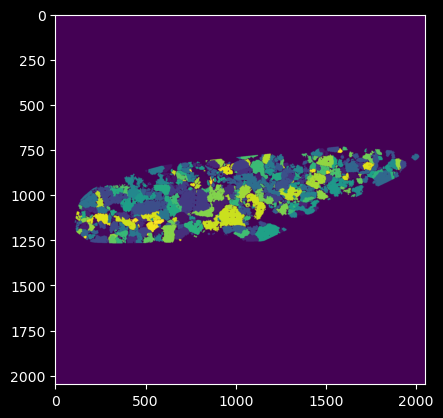

In [7]:
plt.figure()
plt.imshow(full_segmentation)
plt.show()

The probelem we still have is that we set the number of clusters manually, in update and cluster centroids, I recommend checking different number and see how it look this can be done without rerunning the run segemtatino parallel function => to get a good approximation of number of clsuter in the probabalistic segemtation approach 

In [ ]:
#This is to check the number of cluster you get in each individual run
len_list = []
for label_dict in centroids_dict.values():
    len_list.append(len(label_dict.keys()))

print(f"Average number of clusters per run: {np.mean(np.array(len_list))}, which is an ok estimate on what to set the nunber of clusters")

In [8]:
#This can be used to build a histogram of the cell sizes => best to average it out over the layers, the values are the size in microns


size_list = []
for regions in measure.regionprops(full_segmentation):
    size_list.append(regions.area)
size_list_area = [np.sqrt(area * 0.51 * (0.51*3.073)) for area in size_list]
size_list_filtered = [size for size in size_list_area if size > 1]


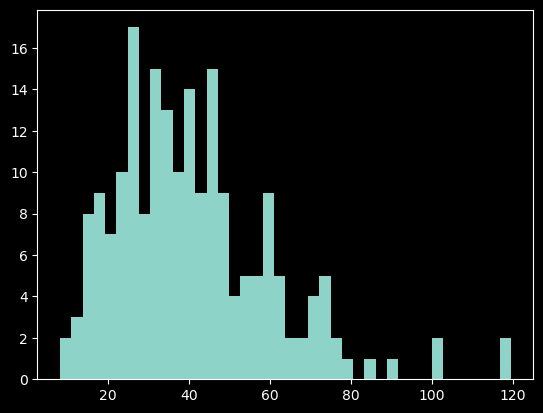

In [9]:
plt.figure()
plt.hist(size_list_filtered, bins=40)
plt.show()